# 🧬 Solving the Wound Healing PDE Using Physics-Informed Neural Networks (PINNs)

## 📌 Objective

This notebook focuses on solving the **Fisher-Kolmogorov equation**, a reaction-diffusion partial differential equation (PDE) widely used to model **cell migration and proliferation** in biological processes such as wound healing.

The equation has the form:

$$
\frac{\partial u}{\partial t} = D \frac{\partial}{\partial r} \left( \left(1 - \frac{u}{u_0} \right)^p \frac{\partial u}{\partial r} \right) + s_c u \left(1 - \frac{u}{u_0} \right)
$$


Where:

- \( u(r, t) \): cell density at radial position \( r \) and time \( t \)
- \( D \): diffusion coefficient
- \( s \): scaling factor for the source term
- \( p \): proliferation rate
- \( r \): radial coordinate
- \( t \): time

---

## 🧠 Why Physics-Informed Neural Networks (PINNs)?

Traditional PDE solvers require discretization of space and time, which can be expensive and inflexible. **PINNs** integrate the **physical laws (PDEs)** directly into the training process of a neural network, enabling:

- Generalization across initial and boundary conditions
- Continuous solution without mesh
- Better handling of sparse and noisy data

---

## ⚙️ Workflow Summary

The steps followed in this notebook are:

1. **Import dependencies** and required libraries.
2. **Load the dataset** representing simulation or experimental data from wound healing.
3. **Normalize the inputs and outputs** for more effective training.
4. **Split the data** into training and testing sets.
5. **Define the PINN architecture** using TensorFlow.
6. **Set up the PDE residual** to guide the neural network via physics constraints.
7. **Train the PINN** to fit the data while minimizing both data and PDE loss.
8. **Visualize the results** to evaluate how well the PINN approximates the PDE solution.

This approach blends machine learning with classical physics to provide a flexible and robust method for solving biological PDEs.


In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf 
import matplotlib.pyplot as plt
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2025-06-14 19:17:00.098897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749928620.282160      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749928620.336193      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/wound-healing/wound_healing_nn_data.csv


### 📄 Loading Dataset

This cell loads the wound healing data from a CSV file. The dataset includes:

- Spatial (`r`) and temporal (`t`) coordinates,
- Diffusion coefficient `D`,
- Source term scaling `sc`,
- Proliferation rate `p`,
- Initial condition `u0`, and
- Target solution `u`.



In [2]:
df = pd.read_csv(r'/kaggle/input/wound-healing/wound_healing_nn_data.csv')
df.head()

,case,r,t,u,r0,u0,D,sc,p
0,1,0.285,27.0,9.971926e-01,0.5,1.0,2.000000e-09,0.000008,0
1,3,0.070,18.0,7.000000e-02,0.5,1.0,2.000000e-09,0.000008,5
2,3,0.470,0.0,0.000000e+00,0.5,1.0,2.000000e-09,0.000008,5
3,3,0.240,15.0,2.400000e-01,0.5,1.0,2.000000e-09,0.000008,5
4,0,0.165,3.0,5.411432e-07,0.5,1.0,2.000000e-09,0.000000,0


### 🔄 Preprocessing and Scaling

This cell performs normalization using `MinMaxScaler` on the features:

- Scales spatial and temporal coordinates (`r`, `t`), diffusion (`D`), source coefficient (`sc`), and proliferation rate (`p`).
- Retains the initial condition `u0` and appends it between scaled inputs.
- Also normalizes the target solution `u` for stable training.

All scaled data is combined into `Input_scaled` for model input.


In [3]:
from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['r', 't', 'D', 'sc', 'p']
u0 = df[['u0']].values 
to_scale = df[cols_to_scale].values

Input_scaler = MinMaxScaler()
scaled = Input_scaler.fit_transform(to_scale)

Input_scaled = np.concatenate([scaled[:, :2], u0, scaled[:, 2:]], axis=1)

u = df['u'].values.reshape(-1, 1)
u_scaler = MinMaxScaler()
u_scaled = u_scaler.fit_transform(u)


In [4]:
from sklearn.model_selection import train_test_split
input_train, input_test, u_train, u_test = train_test_split(Input_scaled, u_scaled, test_size=0.2, random_state=42)


### 🔁 Converting to Tensors

The NumPy arrays for training and testing data are converted into TensorFlow tensors to be used for model training and evaluation.


In [5]:
input_train_tf = tf.convert_to_tensor(input_train, dtype=tf.float32)
input_test_tf = tf.convert_to_tensor(input_test, dtype=tf.float32)
u_train_tf = tf.convert_to_tensor(u_train, dtype=tf.float32)
u_test_tf = tf.convert_to_tensor(u_test, dtype=tf.float32)

I0000 00:00:1749928633.622802      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


### 🧠 Defining and Training the PINN

This block defines the **Physics-Informed Neural Network (PINN)** using TensorFlow's Keras API. It includes:

- A deep feedforward architecture with ReLU activations, batch normalization, and dropout for regularization.
- A custom `physics_loss` function that encodes the Fisher-Kolmogorov PDE:
  - Computes gradients with respect to `r` and `t` using `tf.GradientTape`.
  - Constructs PDE residual using the differential terms and model output.
  - Adds positivity and upper-bound constraints to maintain physical plausibility.

#### Training Stages:
1. **Stage 1 - Data Fit**: The model is first trained to minimize the data loss alone.
2. **Stage 2 - PINN Training**: Adds physics loss using the PDE residual.
3. **Stage 3 - Fine-Tuning**: Reduces physics weight to refine the prediction and maintain smoothness.


In [6]:
import tensorflow as tf

class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(256, activation='relu', 
                                          kernel_initializer='glorot_normal')
        self.dense2 = tf.keras.layers.Dense(256, activation='relu',
                                          kernel_initializer='glorot_normal')
        self.dense3 = tf.keras.layers.Dense(256, activation='relu',
                                          kernel_initializer='glorot_normal')
        self.dense4 = tf.keras.layers.Dense(128, activation='relu',
                                          kernel_initializer='glorot_normal')
        
        self.output_layer = tf.keras.layers.Dense(1, kernel_initializer='glorot_normal')
        
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()
        
        self.dropout1 = tf.keras.layers.Dropout(0.1)
        self.dropout2 = tf.keras.layers.Dropout(0.1)
    
    def call(self, inputs, training=False):
        x = inputs        
        x = self.dense1(x)
        x = self.bn1(x, training=training)
        x = self.dropout1(x, training=training)
        
        x = self.dense2(x)
        x = self.bn2(x, training=training)
        x = self.dropout2(x, training=training)
        
        x = self.dense3(x)
        x = self.bn3(x, training=training)
        
        x = self.dense4(x)
        output = self.output_layer(x)
        
        return output

def physics_loss(model, inputs):
    r = inputs[:, 0:1]
    t = inputs[:, 1:2]
    u0 = inputs[:, 2:3]
    D = inputs[:, 3:4]
    sc = inputs[:, 4:5]
    p = inputs[:, 5:6]
    
    eps = 1e-8
    u0_safe = tf.maximum(tf.abs(u0), eps)
    D_safe = tf.maximum(tf.abs(D), eps)
    
    r_var = tf.Variable(r, trainable=False)
    t_var = tf.Variable(t, trainable=False)
    
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([r_var, t_var])
        
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([r_var, t_var])            
            inputs_watched = tf.concat([r_var, t_var, u0, D, sc, p], axis=1)            
            u_pred = model(inputs_watched, training=True)
        u_r = tape2.gradient(u_pred, r_var)
        u_t = tape2.gradient(u_pred, t_var)
        del tape2    
    u_rr = tape1.gradient(u_r, r_var) if u_r is not None else None
    del tape1
    u_r = tf.zeros_like(r) if u_r is None else u_r
    u_t = tf.zeros_like(t) if u_t is None else u_t
    u_rr = tf.zeros_like(r) if u_rr is None else u_rr
    
    u_ratio = u_pred / u0_safe
    ratio_term = tf.maximum(1.0 - u_ratio, eps)
    
    growth_term = sc * u_pred * (1.0 - u_ratio)
    
    power_term = tf.pow(ratio_term, p)
    power_term_p_minus_1 = tf.pow(ratio_term, tf.maximum(p - 1, eps))
    
    D1 = D_safe * power_term * u_rr
    D2 = tf.square(u_r) * p * D_safe * power_term_p_minus_1 * (-1.0 / u0_safe)
    
    # PDE: u_t = growth_term + D1 + D2
    pde_residual = u_t - growth_term - D1 - D2
    
    pde_loss = tf.reduce_mean(tf.square(pde_residual))
    
    positivity_loss = tf.reduce_mean(tf.square(tf.minimum(u_pred, 0.0)))
    upper_bound_loss = tf.reduce_mean(tf.square(tf.maximum(u_pred - 2.0 * u0_safe, 0.0)))
    
    total_physics_loss = pde_loss + 0.1 * positivity_loss + 0.1 * upper_bound_loss
    
    return total_physics_loss

model = PINN()

print("\nStage 1: Data-only training...")
optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.001)
for epoch in range(1000):
    with tf.GradientTape() as tape:
        pred = model(input_train_tf, training=True)
        data_loss = tf.reduce_mean(tf.square(pred - u_train_tf))
        total_loss = data_loss
    
    grads = tape.gradient(total_loss, model.trainable_variables)
    grads = [tf.clip_by_norm(grad, 1.0) if grad is not None else grad for grad in grads]
    optimizer1.apply_gradients(zip(grads, model.trainable_variables))
    
    if epoch % 200 == 0:
        print(f"[Data Phase] Epoch {epoch}, Data Loss: {data_loss.numpy():.6f}")

print("\nStage 2: Physics-informed training...")
optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.0005)
best_loss = float('inf')
patience = 0
max_patience = 500

for epoch in range(2000):
    with tf.GradientTape() as tape:
        pred = model(input_train_tf, training=True)
        data_loss = tf.reduce_mean(tf.square(pred - u_train_tf))
        
        # Use original inputs for physics loss
        phys_loss = physics_loss(model, input_train_tf)
        
        # Adaptive weighting
        physics_weight = min(1.0, epoch / 500.0)  # Gradually increase physics weight
        total_loss = data_loss + physics_weight * phys_loss
    
    grads = tape.gradient(total_loss, model.trainable_variables)
    grads = [tf.clip_by_norm(grad, 1.0) if grad is not None else grad for grad in grads]
    optimizer2.apply_gradients(zip(grads, model.trainable_variables))
    
    # Early stopping
    if total_loss < best_loss:
        best_loss = total_loss
        patience = 0
    else:
        patience += 1
    
    if epoch % 200 == 0:
        print(f"[Physics Phase] Epoch {epoch}, Data Loss: {data_loss.numpy():.6f}, "
              f"Physics Loss: {phys_loss.numpy():.6f}, Weight: {physics_weight:.3f}")
    
    if patience > max_patience:
        print(f"Early stopping at epoch {epoch}")
        break
    
    if total_loss < 0.0001:
        print("Converged!")
        break

print("\nStage 3: Fine-tuning...")
optimizer3 = tf.keras.optimizers.Adam(learning_rate=0.0001)
for epoch in range(500):
    with tf.GradientTape() as tape:
        pred = model(input_train_tf, training=True)
        data_loss = tf.reduce_mean(tf.square(pred - u_train_tf))
        phys_loss = physics_loss(model, input_train_tf)
        total_loss = data_loss + 0.5 * phys_loss  # Reduced physics weight for fine-tuning
    
    grads = tape.gradient(total_loss, model.trainable_variables)
    grads = [tf.clip_by_norm(grad, 0.5) if grad is not None else grad for grad in grads]
    optimizer3.apply_gradients(zip(grads, model.trainable_variables))
    
    if epoch % 100 == 0:
        print(f"[Fine-tune] Epoch {epoch}, Data Loss: {data_loss.numpy():.6f}, "
              f"Physics Loss: {phys_loss.numpy():.6f}")

print("Training completed!")


Stage 1: Data-only training...
[Data Phase] Epoch 0, Data Loss: 3.668322
[Data Phase] Epoch 200, Data Loss: 0.004067
[Data Phase] Epoch 400, Data Loss: 0.002271
[Data Phase] Epoch 600, Data Loss: 0.001528
[Data Phase] Epoch 800, Data Loss: 0.001168

Stage 2: Physics-informed training...
[Physics Phase] Epoch 0, Data Loss: 0.001115, Physics Loss: 0.207930, Weight: 0.000
[Physics Phase] Epoch 200, Data Loss: 0.001167, Physics Loss: 0.001720, Weight: 0.400
[Physics Phase] Epoch 400, Data Loss: 0.001508, Physics Loss: 0.000937, Weight: 0.800
Early stopping at epoch 501

Stage 3: Fine-tuning...
[Fine-tune] Epoch 0, Data Loss: 0.001027, Physics Loss: 0.000502
[Fine-tune] Epoch 100, Data Loss: 0.000987, Physics Loss: 0.000479
[Fine-tune] Epoch 200, Data Loss: 0.000904, Physics Loss: 0.000480
[Fine-tune] Epoch 300, Data Loss: 0.000891, Physics Loss: 0.000417
[Fine-tune] Epoch 400, Data Loss: 0.000880, Physics Loss: 0.000394
Training completed!


### 📈 Evaluation and Diagnostics

This cell evaluates the trained PINN model on the test set:

- Computes **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)**.
- Calculates the **coefficient of determination \( R^2 \)** to quantify prediction accuracy.
- Prints ranges and means of predictions vs. ground truth to assess generalization and bias.


In [7]:
u_pred = model(input_test_tf)

# Test the model on the test split
test_loss = tf.reduce_mean(tf.square(u_pred - u_test_tf))
test_mae = tf.reduce_mean(tf.abs(u_pred - u_test_tf))

print(f"\nTest Results:")
print(f"Test MSE: {test_loss.numpy():.6f}")
print(f"Test MAE: {test_mae.numpy():.6f}")

# Calculate R-squared
ss_res = tf.reduce_sum(tf.square(u_test_tf - u_pred))
ss_tot = tf.reduce_sum(tf.square(u_test_tf - tf.reduce_mean(u_test_tf)))
r2_score = 1 - (ss_res / ss_tot)
print(f"Test R²: {r2_score.numpy():.4f}")

# Additional diagnostic information
print(f"\nDiagnostic Info:")
print(f"Prediction range: [{tf.reduce_min(u_pred).numpy():.4f}, {tf.reduce_max(u_pred).numpy():.4f}]")
print(f"True values range: [{tf.reduce_min(u_test_tf).numpy():.4f}, {tf.reduce_max(u_test_tf).numpy():.4f}]")
print(f"Mean prediction: {tf.reduce_mean(u_pred).numpy():.4f}")
print(f"Mean true value: {tf.reduce_mean(u_test_tf).numpy():.4f}")


Test Results:
Test MSE: 0.000171
Test MAE: 0.008170
Test R²: 0.9314

Diagnostic Info:
Prediction range: [0.7406, 1.0248]
True values range: [0.8709, 1.0000]
Mean prediction: 0.9138
Mean true value: 0.9112


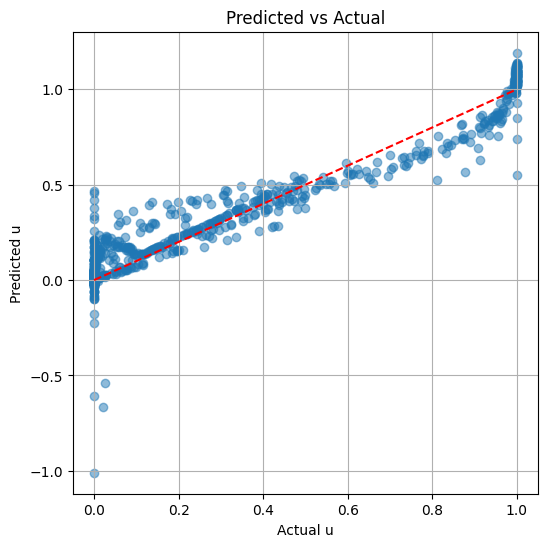

In [8]:
y_pred = u_scaler.inverse_transform(u_pred)
y_test_original = u_scaler.inverse_transform(u_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test_original, y_pred, alpha=0.5)
plt.xlabel("Actual u")
plt.ylabel("Predicted u")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.plot([0,1],[0,1], 'r--')
plt.show()